# Measuring the divergence between models.

We have lots of ways of comparing different models of the same data. One model may be more "accurate" than the other--or have better "precision" or "recall."

But what if you want to compare models of _different_ data? For instance, say we we have one model that separates science fiction from mainstream fiction, and another that separates fantasy from the mainstream. We'd like to be able to ask _how similar_ the two models are. Are SF and fantasy different from mainstream fiction in similar ways?

One intuitive way to pose this question might be to ask, "Can a model that separates SF from the mainstream also spearate fantasy?" In practice, it can, but it does so somewhat worse than a model originally trained on fantasy.

That leads us to the question explored in this notebook: can we explain what we mean when we say "model A performs somewhat worse on dataset B"? What counts as significantly worse? And also, can we compare the divergences between models (A -> B and C -> D) by reference to any shared yardstick? 

For instance, suppose I also train multiple models of science fiction in different periods. Just as a model of SF loses accuracy on fantasy, a model of 1970s SF will lose some accuracy if asked to make predictions about the 19th century. We might understand that loss of accuracy as a measure of generic change. Can we meaningfully compare this measure of change to the distance between genres? Could we say, for instance, "In the 1970s, SF was about as different from fantasy as it was from its own past in the era of Jules Verne?"

### The general approach

We don't start out knowing, in principle, which genres are more or less similar to each other, so it's hard to calibrate the space of similarity between models.

We do know, however, that a model asked to discriminate between two random samples of the same set will produce very little useful information. So we might reasonably use that to mark "zero" on our thermometer. Whatever boundary (A vs. B) we want to model, a model of an entirely random boundary should count as "not at all meaningfully similar to it."

Then we could calibrate the space between A vs. B and sheer randomness by gradually mixing B into A. For instance, we could start diluting A by replacing 5% of the A examples with examples of B. This will weaken our model; the A/B boundary will be less accurately traced. Then we replace 10% of the examples of A. Then 15%, and so on. By the time we're done, we have twenty models defining the space between A/B and a random boundary.

### Choosing a metric

I ran that test, using science fiction (labeled by librarians or OCLC) as A and a collection of fiction selected randomly from HathiTrust for B. (See labnotebook.md for details of the code used.)

I'm going to read in the results of the dilution below as **sfvsrand**. Each row in this dataset actually defines a _comparison_ between two models rather than a single model. There are 86 comparisons and only 41 models. But the rows do also reference the accuracy of the original models, so we can use them to plot the original models' accuracy if we don't mind plotting the same dot several times.

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
%matplotlib inline

In [48]:
sfvsrand = pd.read_csv('sf_divergences.tsv', sep = '\t')
sfvsrand.head()

,name1,name2,size,acc1,acc2,ratiodiff,pearson,spearman,spear1on2,spear2on1,loss,loss1on2,loss2on1,kl
0,iter5_size80_ratio0,iter5_size80_ratio5,80,0.9375,0.85000,0.05,0.942170,0.933723,0.927408,0.939505,0.012500,-0.00625,0.03125,9.596914
1,iter5_size80_ratio0,iter5_size80_ratio10,80,0.9375,0.85000,0.10,0.878406,0.870351,0.857286,0.882295,-0.006250,-0.02500,0.01250,7.161312
2,iter5_size80_ratio0,iter5_size80_ratio15,80,0.9375,0.81250,0.15,0.858962,0.845299,0.809862,0.874590,0.046875,0.05000,0.04375,8.839486
3,iter5_size80_ratio0,iter5_size80_ratio20,80,0.9375,0.77500,0.20,0.890163,0.895295,0.877218,0.910837,0.025000,-0.02500,0.07500,24.931871
4,iter5_size80_ratio0,iter5_size80_ratio25,80,0.9375,0.79375,0.25,0.865169,0.859912,0.845822,0.872803,0.040625,0.00625,0.07500,9.677111


#### the accuracies of the models, considered separately

As you can see below, there's a gratifyingly linear relationship between the amount of dilution we apply and the accuracy of the resulting model.

The accuracies don't get *quite* down to a flat .50; that's because our model-tuning method overfits a little through parameter selection, in an attempt to give every dataset the benefit of a doubt. If you were testing algorithms, you might not want to do this, but we're interested in the data, and applied consistently it does no harm.

In any case, the difference between .90 and .52 or whatever is sufficiently clear.

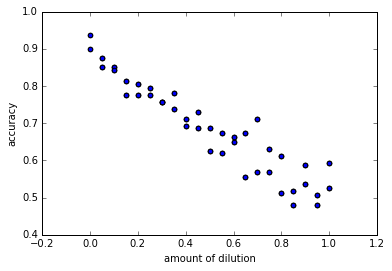

r = -0.943463824967


In [49]:
ax = sfvsrand.plot.scatter('ratiodiff', 'acc2')
ax.set_xlabel('amount of dilution')
ax.set_ylabel('accuracy')
plt.show()
print("r = " + str(pearsonr(sfvsrand.ratiodiff, sfvsrand.acc2)[0]) )

#### loss of accuracy

But the accuracies of the models, considered separately, don't do much for us. We definitely cannot conclude that every 70% accurate model has some relation to science fiction. It may have no relation at all! We're interested in the accuracies we get when we apply one model to another model's data.

For instance what if we apply the diluted models back to the clean data, and ask how much accuracy they lose, compared to the models that were trained on those original data samples

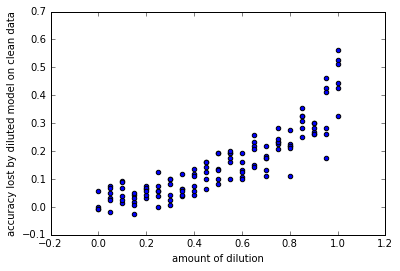

r = 0.875701918796


In [50]:
ax = sfvsrand.plot.scatter('ratiodiff', 'loss2on1')
ax.set_xlabel('amount of dilution')
ax.set_ylabel('accuracy lost by diluted model on clean data')
plt.show()
print("r = " + str(pearsonr(sfvsrand.ratiodiff, sfvsrand.loss2on1)[0]) )

It's not exactly a linear relationship, but it's clear that diluted models lose more accuracy. What if we try vice-versa? Do models trained on clean data also lose accuracy relative to models trained on the diluted data?

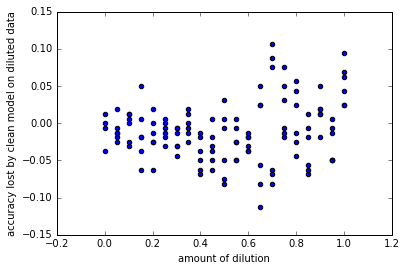

r = 0.181158236426


In [51]:
ax = sfvsrand.plot.scatter('ratiodiff', 'loss1on2')
ax.set_xlabel('amount of dilution')
ax.set_ylabel('accuracy lost by clean model on diluted data')
plt.show()
print("r = " + str(pearsonr(sfvsrand.ratiodiff, sfvsrand.loss1on2)[0]) )

Not so much. "Loss of accuracy" can be an asymmetric relationship. If category B is not very coherent to start with, a model of category A can sometimes make predictions that are almost as good as a model trained on B's data--even when a model trained on B is uninformative about A! 

This is admittedly most likely to happen in the artificial situation we have constructed (where B is just a diluted version of A). But it's not impossible to imagine an analogous asymmetry occurring in the real world. E.g, one could imagine that hardboiled detective novels, or hard SF, are "extreme" or "stylized" versions of a genre. More generally, whenever we were comparing models with different base accuracies, we would have to worry that "loss of accuracy" was an asymmetric measure.

So let's look for other metrics. "Accuracy" was to begin with a bit crude, since it depends on a binary division into two classes. What if we ask a more detailed question, about the model's ability to sort instances according to their probability of belonging to the specified genre: P(genre|text)? We could measure this, for instance, through correlation.

#### correlation coefficients

Let's look at the Spearman correlation coefficient, which compares the way two models rank the texts in a dataset. First let's ask the model trained on diluted data to make predictions on clean data, and then calculate the correlation between those predictions and the predictions made by a model actually trained on clean data.

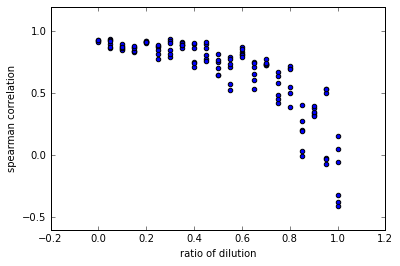

r = -0.795243307101


In [63]:
plt.scatter(sfvsrand.ratiodiff, sfvsrand.spear2on1)
plt.xlabel('ratio of dilution')
plt.ylabel('spearman correlation')
plt.show()
print("r = " + str(pearsonr(sfvsrand.ratiodiff, sfvsrand.spear2on1)[0]) )

It's not very linear, but that's because correlation is capped at 1. We can fix that with a Fisher's z-transform, rendering the underlying metric linear. It's equivalent to arctanh.

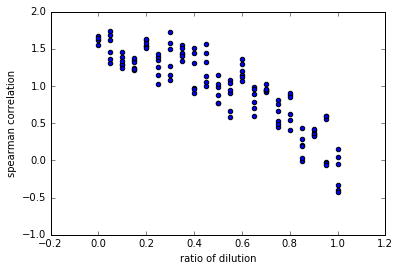

r = -0.87237385891


In [64]:
plt.scatter(sfvsrand.ratiodiff, np.arctanh(sfvsrand.spear2on1))
plt.xlabel('ratio of dilution')
plt.ylabel('spearman correlation')
plt.show()
print("r = " + str(pearsonr(sfvsrand.ratiodiff, np.arctanh(sfvsrand.spear2on1))[0]) )

Hey, that's about as strong a linear relationship as our original metric, "loss of accuracy." Does it also tend in practice to be symmetric?

Let's now ask a model trained on clean data (A) to make predictions about a diluted dataset (B). We saw that these can be almost as "accurate" as a (not very accurate) model trained on diluted data. But we might hope that ability-to-rank is a sterner test, which will prove that A has no real congruence with B.

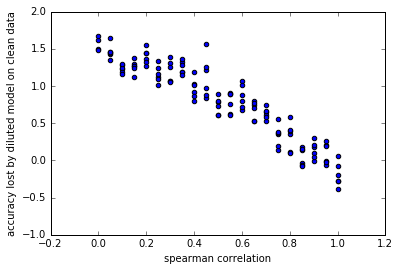

r = -0.938319625156


In [54]:
plt.scatter(sfvsrand.ratiodiff, np.arctanh(sfvsrand.spear1on2))
plt.xlabel('spearman correlation')
plt.ylabel('accuracy lost by diluted model on clean data')
plt.show()
print("r = " + str(pearsonr(sfvsrand.ratiodiff, np.arctanh(sfvsrand.spear1on2))[0]) )

Yes, loss of correlation is symmetric! It's not a mathematical guarantee, but the correlation of A on B's data tracks the correlation of B on A's data pretty closely. In fact, it looks the original model's inability to sort a transformed dataset is an even stronger predictor of the dataset's alienation from our original genre. This difference is slight, however, and it might be due to the artificial nature of our test. (There are instances in the diluted dataset that will literally be impossible to predict, so A is sort of guaranteed to fail.)

Since these two measures tend to correlate, we could also average them, to produce a robust measure of divergence between two models. By calling this "robust," I mean that in the real world, we'll never know in practice which model is "A" and which one is "B." We might as well consider both models' perspectives on the other.

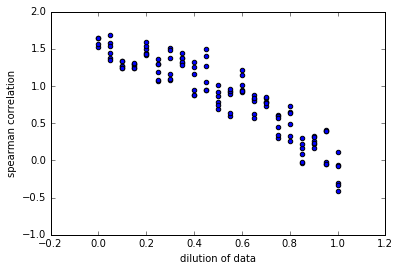

r = -0.915226600564


In [67]:
plt.scatter(sfvsrand.ratiodiff, np.arctanh(sfvsrand.spearman))
plt.xlabel('dilution of data')
plt.ylabel('spearman correlation')
plt.show()
print("r = " + str(pearsonr(sfvsrand.ratiodiff, np.arctanh(sfvsrand.spearman))[0]) )

#### our final metric

So we're measuring the divergence of models by averaging:

    spearman(modelA's prediction on Adata, modelB's prediction on Adata) and 
    spearman(modelA's prediction on Bdata, modelB's prediction on Bdata)

It doesn't matter greatly whether we use Spearman or Pearson correlation. The results are very close. It *does* matter that we transform the two correlation coefficients with np.arctanh() before averaging them.

I tried a few other things, including KL divergence. They didn't in practice seem to work as well.

### Calibration problems

However, if we want to render different sets of models comparable, we need some way to translate a correlation coefficient into a specific "distance." Although real-world models aren't really diluted versions of each other, we might use "percentage of dilution" as a rough and ready yardstick for this. "Pre-World-War-II SF is about as informative about the postwar genre ... as a model of the postwar genre would be if it were diluted by 25%." That's somewhat intelligible, and in any case it permits us to make comparisons between different pairs.

However, to use that yardstick, we'll need to translate our y axis in the graph above into a specific x value. And this is complicated by a messy reality: the different categories we will be modeling max out at different degrees of correlation.

For instance, distinguishing science fiction from *fantasy* is significantly harder than distinguishing it from random (mainstream) fiction. Models attempting to trace this blurrier boundary top out at roughly 77% accuracy, and their predictions about specific books don't correlate with each other as strongly as models of sf-vs-random. See the red line below:

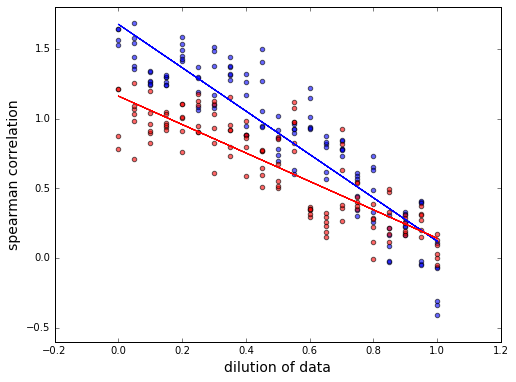

In [106]:
fanvsf = pd.read_csv('fsf_divergences.tsv', sep = '\t')

fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(sfvsrand.ratiodiff, np.arctanh(sfvsrand.spearman), c ='b', alpha = 0.6)
plt.scatter(fanvsf.ratiodiff, np.arctanh(fanvsf.spearman), c = 'r', alpha = 0.6)
plt.xlabel('dilution of data', fontsize = 14)
plt.ylabel('spearman correlation', fontsize = 14)


z = np.polyfit(sfvsrand.ratiodiff, np.arctanh(sfvsrand.spearman), 1)
p = np.poly1d(z)
ax.plot(sfvsrand.ratiodiff, p(sfvsrand.ratiodiff), linestyle = (0, (5, 5)), c = 'b')

z = np.polyfit(fanvsf.ratiodiff, np.arctanh(fanvsf.spearman), 1)
p = np.poly1d(z)
ax.plot(fanvsf.ratiodiff, p(fanvsf.ratiodiff), linestyle = (0, (5, 5)), c = 'r')

plt.ylim((-0.6, 1.8))
plt.show()

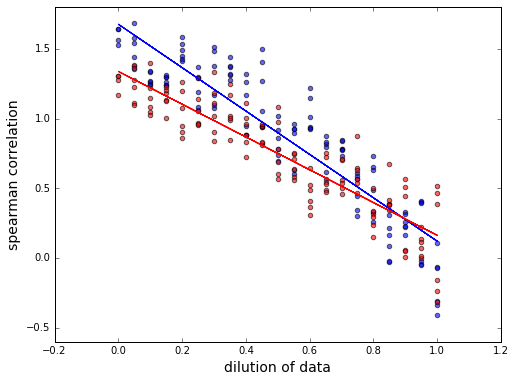

In [120]:
fant = pd.read_csv('fantasy_divergences.tsv', sep = '\t')

fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(sfvsrand.ratiodiff, np.arctanh(sfvsrand.spearman), c ='b', alpha = 0.6)
plt.scatter(fant.ratiodiff, np.arctanh(fant.spearman), c = 'r', alpha = 0.6)
plt.xlabel('dilution of data', fontsize = 14)
plt.ylabel('spearman correlation', fontsize = 14)


z = np.polyfit(sfvsrand.ratiodiff, np.arctanh(sfvsrand.spearman), 1)
p = np.poly1d(z)
ax.plot(sfvsrand.ratiodiff, p(sfvsrand.ratiodiff), linestyle = (0, (5, 5)), c = 'b')

z = np.polyfit(fant.ratiodiff, np.arctanh(fant.spearman), 1)
p = np.poly1d(z)
ax.plot(fant.ratiodiff, p(fant.ratiodiff), linestyle = (0, (5, 5)), c = 'r')

plt.ylim((-0.6, 1.8))
plt.show()

In [119]:
pearsonr(fant.ratiodiff, np.arctanh(fant.spearman))

(-0.9105189063400817, 5.2285781743687875e-49)

In [128]:
allframes = pd.concat([fant, fanvsf, sfvsrand])

In [123]:
allframes = allframes[allframes.ratiodiff < .1]

In [126]:
pearsonr(allframes.acc2 + allframes.acc1, np.arctanh(allframes.spearman))

(0.89074649980018217, 4.2854398054602236e-11)

In [140]:
import statsmodels.formula.api as smf
lm = smf.ols(formula='ratiodiff ~ spearman + spearman:acc1', data=allframes).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ratiodiff   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     516.0
Date:                Mon, 25 Dec 2017   Prob (F-statistic):          1.24e-107
Time:                        20:43:43   Log-Likelihood:                 170.17
No. Observations:                 372   AIC:                            -334.3
Df Residuals:                     369   BIC:                            -322.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.0519      0.019     56.215      0.000       1.015       1.089
spearman         -2.0390      0.174    -11.721      0.000      -2.381      -1.697
spearman:acc1     1.2695      0.192      6.615      0.000       0.892       1.647
==============================================================================
Omnibus:                        8.532   Durbin-Watson:                   1.162
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                5.165
Skew:                           0.099   Prob(JB):                       0.0756
Kurtosis:                       2.458   Cond. No.                         41.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [131]:
import math
math.sqrt(.737)

0.8584870412533901